In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

# DATA 607 - Machine Learning

## Class 2: Model evaluation: making choices

### 2025.02.26

- Any nontrivial modeling project involves making many choices.

- You can't make choices in a principled way without concrete criteria for evaluating those choices. These criteria need to reflect your project's goals.

- In this course, the unifying goal of ***maximizing predictive accuracy*** will inform most of our modeling choices.

- In real life, your choices may be constrained by other considerations: organizational, regulatory, ethical, practical, ...

### Combinatorial explosion 🤯

- Many possible models for any given dataset. You already know how to use them all! (`model.fit`, `model.predict`)

- Among the regression models implemented in scikit-learn:
  - linear models
  - support vector machines
  - nearest neighbors
  - Gaussian processes
  - decision trees
  - neural networks

- Each exposes "knobs to twiddle" &mdash; **hyperparameters**.

- They can be combined in various ways into **ensembles**.

- And composed &mdash; into **pipelines** &mdash; with numerous data preprocessing, transformation, or feature engineering strategies.

- ***This course's primary "deliverable": techniques for navigating this complexity.***

### Goals guide choices

- Articulate your project's **goals** explicitly.

  - **🫤** My project's goal is to understand how scholarship amount influences an admission offer's chances of being accepted.

  - **🙂** My project's goal is to train a model to predict an admission offer's acceptance/rejection based on scholarship amount and information about the applicant.

- Your goals should explicitly support your organization's.

  - **🤩** My project's goal is to train a model to predict an admission offer's acceptance/rejection based on scholarship amount and information about the applicant. We'll use the predictive model to optmize the admission office's scholarship strategy for (insert *institutional goals for incoming cohort size and strength* here).

  - "Downstream" applications can guide/constrain modeling choices.

### Explicit goals for DATA 607

- **Primary goal:** Develop a flexible, reliable workflow for ***building and evaluating predictive models***, i.e., models for predicting a label $y$ from features $x$.

- **Secondary goal:** Develop familiarity with unsupervised learning's greatest hits.
  - Favorite application of unsupervised learning: *deduping*. (Project recommendation!)

### Metrics: Loss functions and scores

- Used to evaluate predictions.

- Two types:

    - **Loss functions** (error measures): smaller is better.

    - **Scores** (success measures): bigger is better.

- Import from `sklearn.metrics`.


### Metrics for quantitative $y$

- Given: predictions $\hat{y}_i$ for quantitative observations $y_i$

<center>

|Metric|Formula|
|:--:|:--:|
|mean squared error (MSE)|$\displaystyle\frac1n\sum_{i<n}(y_i - \hat{y}_i)^2$|
|mean absolute error (MAE)|$\displaystyle\frac1n\sum_{i<n}\|y_i - \hat{y}_i\|$|
|mean absolute percentage error (MAPE)|$\displaystyle\frac{1}n\sum_{i<n}\left\|\frac{y_i - \hat{y}_i}{y_i}\right\|$|
|$R^2$-score (coefficient of determination)|$\displaystyle 1 - \frac{\sum_i(y_i - \hat{y}_i)^2}{\sum_i (y_i - \bar{y})^2}$, where $\displaystyle\bar{y}=\frac1n\sum_i y_i$|

</center>

In [443]:
from sklearn.metrics import (
    mean_squared_error,
    mean_absolute_error,
    mean_absolute_percentage_error,
)

n = 30
rng = np.random.default_rng(42)
y = rng.normal(loc=10, size=n)
y_pred = y + rng.normal(size=n)

assert np.isclose(mean_squared_error(y, y_pred), np.mean((y - y_pred) ** 2))

#### Exercise: Verify the formulas for MAE and MAPE

Fill in the blanks (`...`).

In [ ]:
assert np.isclose(mean_absolute_error(y, y_pred), np.mean(np.abs(y - y_pred)))
assert np.isclose(
    mean_absolute_percentage_error(y, y_pred), np.mean(np.abs((y - y_pred) / y))
)

### Metrics for qualitative $y$

- Given qualitative predictions $\hat{y}_i$ of qualitative observations $y_i$

<center>

|Metric|Formula|
|:--:|:--:|
|zero-one loss (misclassification rate)|$\displaystyle\frac1n\sum_{i<n}\mathbf{1}(\hat{y}_i \neq y_i)$|
|accuracy score|$\displaystyle\frac1n\sum_{i<n}\mathbf{1}(\hat{y}_i = y_i)$|
|log-loss|$\displaystyle-\frac1n\sum_{i<n}\big(y_i\log p_i + (1 - y_i)\log(1 -  p_i)\big)$|
</center>

- Why might you choose one of these error measures over another?

In [44]:
from sklearn.metrics import accuracy_score, log_loss, zero_one_loss

n = 30
rng = np.random.default_rng(42)
p = rng.uniform(size=n)
y = np.round(p).astype(int)
y_pred = (rng.uniform(size=n) < p).astype(int)

assert np.isclose(zero_one_loss(y, y_pred), np.mean(y != y_pred))

#### Exercise: Verify the formulas for accuracy score and log-loss

Fill in the blanks (`...`).

In [ ]:
assert np.isclose(accuracy_score(y, y_pred), ...)
assert np.isclose(log_loss(y, p), ...)

### Models and their predictive performance

- A **predictive model** $\hat{f}$ is a function mapping a feature vector $x$ to a **prediction** $\hat{f}(x)$. 

- $\hat{f}$ is supposed to model the relationship between $x$ and $y$ for $(x,y)$ drawn from some unknown and unknowable **data-generating distribution**, $p$.

- Let $L$ be a loss function.

- The **predictive error** or **generalization error** of $\hat{f}$ with respect to $L$ is
  $$
  \mathbb{E}[L(y, \hat{f}(x))],
  $$
  where $(x, y)\sim p$ is *independent* of any **training data** used to construct (fit) $\hat{f}$.


### Test sets: Estimating predictive error

- A **test set** for $\hat{f}$ is a dataset $$\{(x_i, y_i):i<n\}$$ independent of any training data used to construct $\hat{f}$.

- Estimate expected values using averages:
  $$
  \mathbb{E}[L(y, \hat{f}(x))]\approx \frac1n \sum_{i<n} L(y_i,\hat{f}(x_i))=\text{test error}
  $$

- **Our modeling decisions will be made to minimize test error.**

- By contrast, average loss over **training data** yields unreliable, biased (optimistic) estimates of predictive error.

### Example: Training error optimism

- Synthetic regression data:
  $$
  \begin{aligned}
  x&\sim \operatorname{Uniform}[0, 1]\\
  y\mid x&\sim \operatorname{Normal}(\mu=x^2, \sigma=0.1)
  \end{aligned}
  $$

- Linear regression model fit on 20 training points.

- Prediction error (MSE and MAE) estimated using 1000 test points.

- Experiment repeated 1000 times.

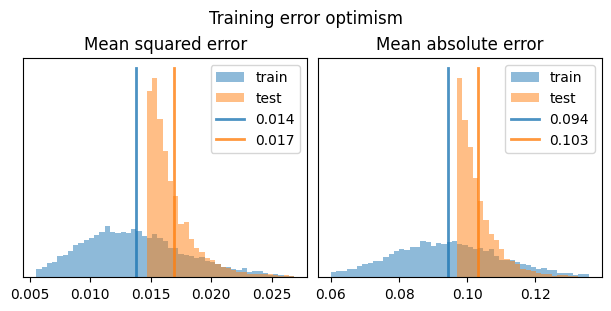

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error


def f(x):
    return x**2


def make_data(n, sigma=0.1, random_state=None):
    rng = np.random.default_rng(random_state)
    x = rng.uniform(size=n)
    y = f(x) + sigma * rng.normal(size=n)
    return x, y


n_train = 20
n_test = 1000
n_repeats = 10_000
n_bins = 50

x_test, y_test = make_data(n_test)
X_test = x_test.reshape(-1, 1)

train_mse = np.zeros(n_repeats)
test_mse = np.zeros(n_repeats)

train_mae = np.zeros(n_repeats)
test_mae = np.zeros(n_repeats)

model = LinearRegression()
for i in range(n_repeats):
    x_train, y_train = make_data(n_train)
    X_train = x_train.reshape(-1, 1)

    model.fit(X_train, y_train)

    train_mse[i] = mean_squared_error(y_train, model.predict(X_train))
    test_mse[i] = mean_squared_error(y_test, model.predict(X_test))

    train_mae[i] = mean_absolute_error(y_train, model.predict(X_train))
    test_mae[i] = mean_absolute_error(y_test, model.predict(X_test))

m = min(np.quantile(train_mse, 0.01), np.quantile(test_mse, 0.01))
M = max(np.quantile(train_mse, 0.99), np.quantile(test_mse, 0.99))
bins = np.linspace(m, M, 50)

fig, (a0, a1) = plt.subplots(nrows=1, ncols=2, figsize=(6, 3), layout="constrained")
fig.suptitle("Training error optimism")

a0.hist(train_mse, density=True, alpha=0.5, label="train", bins=bins)
a0.hist(test_mse, density=True, alpha=0.5, label="test", bins=bins)
ylim = a0.get_ylim()
a0.plot(
    [train_mse.mean(), train_mse.mean()],
    ylim,
    color="C0",
    alpha=0.8,
    lw=2,
    label=f"{train_mse.mean():.3f}",
)
a0.plot(
    [test_mse.mean(), test_mse.mean()],
    ylim,
    color="C1",
    alpha=0.8,
    lw=2,
    label=f"{test_mse.mean():.3f}",
)
a0.set_yticks([])
a0.set_title("Mean squared error")
a0.legend()

m = min(np.quantile(train_mae, 0.01), np.quantile(test_mae, 0.01))
M = max(np.quantile(train_mae, 0.99), np.quantile(test_mae, 0.99))
bins = np.linspace(m, M, 50)


a1.hist(train_mae, density=True, alpha=0.5, label="train", bins=bins)
a1.hist(test_mae, density=True, alpha=0.5, label="test", bins=bins)
ylim = a1.get_ylim()
a1.plot(
    [train_mae.mean(), train_mae.mean()],
    ylim,
    color="C0",
    alpha=0.8,
    lw=2,
    label=f"{train_mae.mean():.3f}",
)
a1.plot(
    [test_mae.mean(), test_mae.mean()],
    ylim,
    color="C1",
    alpha=0.8,
    lw=2,
    label=f"{test_mae.mean():.3f}",
)

a1.set_yticks([])
a1.set_title("Mean absolute error")
a1.legend()

plt.show()

#### Exercise: Training error for 1-nearest neighbors

1. Generate a synthetic training dataset of size 20 using the `make_data` function from the previous example.

2. Make a scatter plot of the data.

3. Fit a 1-nearest neighbor regression model to the data.

4. Predict $y$-values for a grid of 100 evenly spaced points between 0 and 1 (use `np.linspace`), and plot the resulting regression curve on the same axes as your scatter plot.

5. Can you guess the training MSE and the training MAE of your model from the plot? Can you justify your guess conceptually? Verify your guess computationally by computing the training MSE and the training MAE.

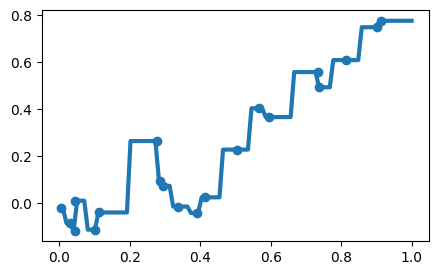

In [ ]:
from sklearn.neighbors import KNeighborsRegressor


def f(x):
    return x**2


def make_data(n, sigma=0.1, random_state=None):
    rng = np.random.default_rng(random_state)
    x = rng.uniform(size=n)
    y = f(x) + sigma * rng.normal(size=n)
    return x, y


x_train, y_train = make_data(20)
plt.figure(figsize=(5, 3))
plt.scatter(x_train, y_train)

model = KNeighborsRegressor(n_neighbors=1)
model.fit(x_train.reshape(-1, 1), y_train)

u = np.linspace(0, 1, 100)
v = model.predict(u.reshape(-1, 1))
plt.plot(u, v, lw=3)

### Example: Linear regression versus nearest neighbor

- Same protocol as above, except:

  - I fit both linear regression and nearest neighbor models

  - I don't bother with training error.

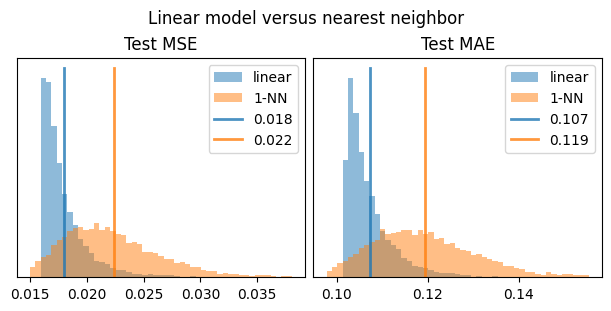

In [175]:
n_train = 20
n_test = 1000
n_repeats = 10_000
n_bins = 50


x_test, y_test = make_data(n_test)
X_test = x_test.reshape(-1, 1)


linear_mse = np.zeros(n_repeats)
linear_mae = np.zeros(n_repeats)

nn_mse = np.zeros(n_repeats)
nn_mae = np.zeros(n_repeats)

linear_model = LinearRegression()
nn_model = KNeighborsRegressor(n_neighbors=1)

for i in range(n_repeats):
    x_train, y_train = make_data(n_train)
    X_train = x_train.reshape(-1, 1)

    linear_model.fit(X_train, y_train)
    linear_mse[i] = mean_squared_error(y_test, linear_model.predict(X_test))
    linear_mae[i] = mean_absolute_error(y_test, linear_model.predict(X_test))

    nn_model.fit(X_train, y_train)
    nn_mse[i] = mean_squared_error(y_test, nn_model.predict(X_test))
    nn_mae[i] = mean_absolute_error(y_test, nn_model.predict(X_test))

m = min(np.quantile(linear_mse, 0.01), np.quantile(nn_mse, 0.01))
M = max(np.quantile(linear_mse, 0.99), np.quantile(nn_mse, 0.99))
bins = np.linspace(m, M, 50)

fig, (a0, a1) = plt.subplots(nrows=1, ncols=2, figsize=(6, 3), layout="constrained")
fig.suptitle("Linear model versus nearest neighbor")

a0.hist(linear_mse, density=True, alpha=0.5, label="linear", bins=bins)
a0.hist(nn_mse, density=True, alpha=0.5, label="1-NN", bins=bins)
ylim = a0.get_ylim()
a0.plot(
    [linear_mse.mean(), linear_mse.mean()],
    ylim,
    color="C0",
    alpha=0.8,
    lw=2,
    label=f"{linear_mse.mean():.3f}",
)
a0.plot(
    [nn_mse.mean(), nn_mse.mean()],
    ylim,
    color="C1",
    alpha=0.8,
    lw=2,
    label=f"{nn_mse.mean():.3f}",
)
a0.set_yticks([])
a0.set_title("Test MSE")
a0.legend()

m = min(np.quantile(linear_mae, 0.01), np.quantile(nn_mae, 0.01))
M = max(np.quantile(linear_mae, 0.99), np.quantile(nn_mae, 0.99))
bins = np.linspace(m, M, 50)


a1.hist(linear_mae, density=True, alpha=0.5, label="linear", bins=bins)
a1.hist(nn_mae, density=True, alpha=0.5, label="1-NN", bins=bins)
ylim = a1.get_ylim()
a1.plot(
    [linear_mae.mean(), linear_mae.mean()],
    ylim,
    color="C0",
    alpha=0.8,
    lw=2,
    label=f"{linear_mae.mean():.3f}",
)
a1.plot(
    [nn_mae.mean(), nn_mae.mean()],
    ylim,
    color="C1",
    alpha=0.8,
    lw=2,
    label=f"{nn_mae.mean():.3f}",
)

a1.set_yticks([])
a1.set_title("Test MAE")
a1.legend()

plt.show()

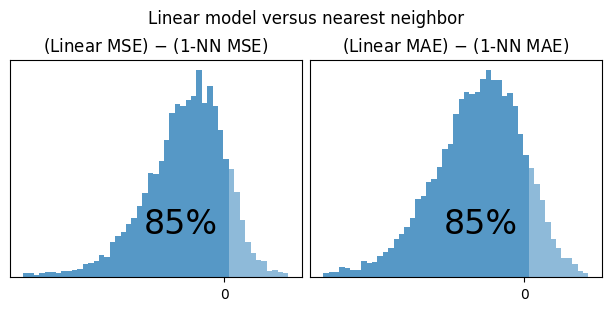

In [ ]:
fig, (a0, a1) = plt.subplots(nrows=1, ncols=2, figsize=(6, 3), layout="constrained")
fig.suptitle("Linear model versus nearest neighbor")

mse_diff = linear_mse - nn_mse
m = np.quantile(mse_diff, 0.005)
M = np.quantile(mse_diff, 0.995)
bins = np.linspace(m, M, 50)
a = a0.hist(mse_diff, bins=bins, alpha=0.5)
a0.hist(
    mse_diff[mse_diff < a[1][np.argmax(a[1] > 0)]], bins=bins, color="C0", alpha=0.5
)
a0.set_yticks([])
a0.set_xticks([0])
a0.set_title("(Linear MSE) $-$ (1-NN MSE)")
xx = np.quantile(a0.get_xlim(), 0.46)
yy = np.quantile(a0.get_ylim(), 0.2)
a0.text(xx, yy, f"{int(100*np.mean(mse_diff < 0))}%", fontsize=24)


mae_diff = linear_mae - nn_mae
m = np.quantile(mae_diff, 0.005)
M = np.quantile(mae_diff, 0.995)
m = np.quantile(mae_diff, 0.005)
M = np.quantile(mae_diff, 0.995)
bins = np.linspace(m, M, 50)
a = a1.hist(mae_diff, bins=bins, alpha=0.5)
a1.hist(
    mae_diff[mae_diff < a[1][np.argmax(a[1] > 0)]], bins=bins, color="C0", alpha=0.5
)
a1.set_yticks([])
a1.set_xticks([0])
a1.set_title("(Linear MAE) $-$ (1-NN MAE)")
xx = np.quantile(a1.get_xlim(), 0.46)
yy = np.quantile(a1.get_ylim(), 0.2)
a1.text(xx, yy, f"{int(100*np.mean(mae_diff < 0))}%", fontsize=24)


plt.show()

In [ ]:
from sklearn.neighbors import KNeighborsRegressor


n_train = 20
n_test = 1000
n_repeats = 10_000
N = np.arange(1, 8)
rng = np.random.default_rng(42)

x_test, y_test = make_data(n_test, random_state=rng)
X_test = x_test.reshape(-1, 1)

linear_mse = np.zeros(n_repeats)
nn_mse = np.zeros((n_repeats, len(N)))

for i in range(n_repeats):
    x_train, y_train = make_data(n_train)
    X_train = x_train.reshape(-1, 1)
    model = LinearRegression()
    model.fit(X_train, y_train)
    linear_mse[i] = mean_squared_error(y_test, model.predict(X_test))
    model.fit(X_train, y_train)
    for j in N:
        model = KNeighborsRegressor(n_neighbors=j)
        model.fit(X_train, y_train)
        nn_mse[i, j - 1] = mean_squared_error(y_test, model.predict(X_test))

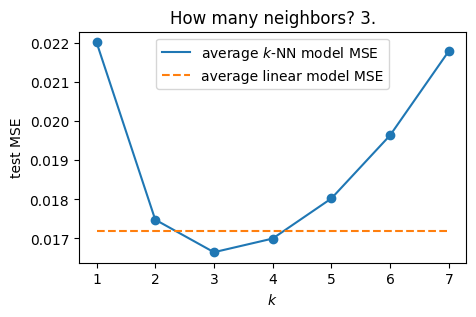

In [279]:
plt.figure(figsize=(5, 3))
plt.scatter(N, nn_mse.mean(axis=0))
plt.plot(N, nn_mse.mean(axis=0), label="average $k$-NN model MSE")
plt.xticks(N)
linear_mean = linear_mse.mean()
plt.plot(
    [min(N), max(N)], [linear_mean, linear_mean], "--", label="average linear model MSE"
)
plt.legend()
plt.title("How many neighbors? 3.")
plt.ylabel("test MSE")
plt.xlabel("$k$")
plt.show()

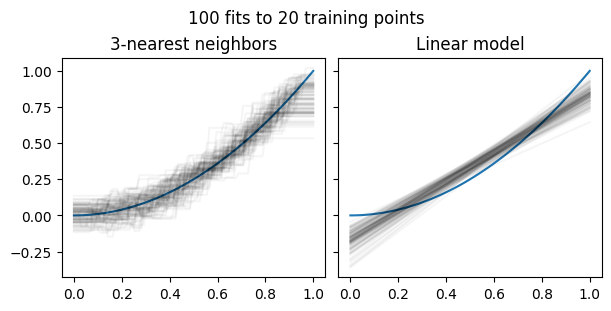

In [275]:
n_train = 20
n_repeats = 100
n_neighbors = 3
rng = np.random.default_rng(42)

u = np.linspace(0, 1, 100)

fig, (a0, a1) = plt.subplots(
    nrows=1, ncols=2, figsize=(6, 3), layout="constrained", sharey=True
)
fig.suptitle("100 fits to 20 training points")

a0.plot(u, f(u))
a1.plot(u, f(u))

linear_model = LinearRegression()
nn_model = KNeighborsRegressor(n_neighbors=3)

for i in range(n_repeats):
    x_train, y_train = make_data(n_train)
    X_train = x_train.reshape(-1, 1)

    nn_model.fit(X_train, y_train)
    v = nn_model.predict(u.reshape(-1, 1))
    a0.plot(u, v, "k", alpha=0.04)
    a0.set_title("3-nearest neighbors")

    linear_model.fit(X_train, y_train)
    v = linear_model.predict(u.reshape(-1, 1))
    a1.plot(u, v, "k", alpha=0.04)
    a1.set_title("Linear model")

#### Exercise:

Determine the value of `n_neighbors` for which a `KNeighborsRegression` fit to the data-generating distribution from Mondays class (see below). Fit 100 models to training sets of size 100. Evaluate on a common test set of size 1000.

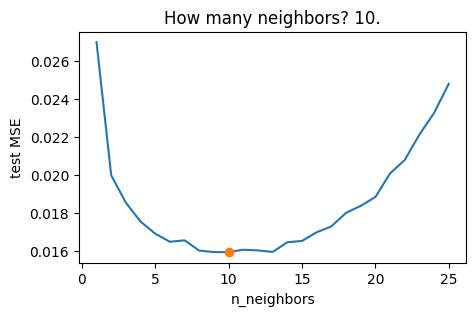

In [ ]:
from sklearn.neighbors import KNeighborsRegressor


def make_data(n=100, random_state=None):
    rng = np.random.default_rng(random_state)
    x = rng.uniform(size=n)
    y = 10 * x * (x - 0.2) * (x - 0.9) + 10 * x * 0.02 * rng.normal(size=n)
    return x, y


n_repeats = 100
n_train = 100
n_test = 1000
N = np.arange(1, 26)
rng = np.random.default_rng(42)

x_test, y_test = make_data(1000, random_state=0)
X_test = x_test.reshape(-1, 1)

plt.figure(figsize=(5, 3))

mse = np.zeros((n_repeats, len(N)))
for i in range(n_repeats):
    for n_neighbors in N:
        x_train, y_train = make_data(n_train, random_state=0)
        X_train = x_train.reshape(-1, 1)
        model = KNeighborsRegressor(n_neighbors=n_neighbors)
        model.fit(X_train, y_train)
        mse[i, n_neighbors - 1] = mean_squared_error(y_test, model.predict(X_test))

mse_mean = mse.mean(axis=0)
plt.plot(N, mse_mean)
plt.xlabel("n_neighbors")
plt.ylabel("test MSE")

n_neighbors = N[mse.mean(axis=0).argmin()]
plt.plot(n_neighbors, mse_mean[n_neighbors - 1], "o")
plt.title(f"How many neighbors? {n_neighbors}.")

plt.show()

### $k$-nearest neighbors classification



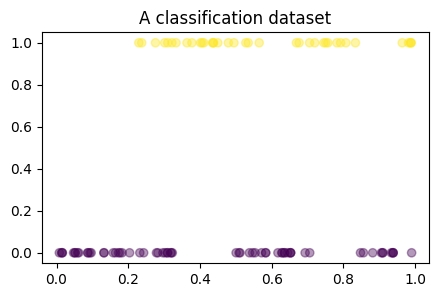

In [ ]:
import numpy as np
from matplotlib import pyplot as plt

rng = np.random.default_rng()


def g(x):
    return np.sin(2.5 * np.pi * x**2) ** 2


def make_data(n):
    x = rng.uniform(size=n)
    y = rng.uniform(size=n) < g(x)
    return x, y


x, y = make_data(100)
X = x.reshape(-1, 1)
plt.figure(figsize=(5, 3))
plt.scatter(x, y, c=y, alpha=0.4)
plt.title("A classification dataset")
plt.show()

In [5]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import zero_one_loss

n_repeats = 200
n_train = 100
n_test = 1000
N = np.arange(1, 16, 2)
loss = np.zeros((n_repeats, len(N)))

x_test, y_test = make_data(n_test)
X_test = x_test.reshape(-1, 1)

for i in range(n_repeats):
    x_train, y_train = make_data(n_train)
    X_train = x_train.reshape(-1, 1)
    for j, n_neighbors in enumerate(N):
        model = KNeighborsClassifier(n_neighbors=n_neighbors)
        model.fit(X_train, y_train)
        loss[i, j] = zero_one_loss(y_test, model.predict(X_test))

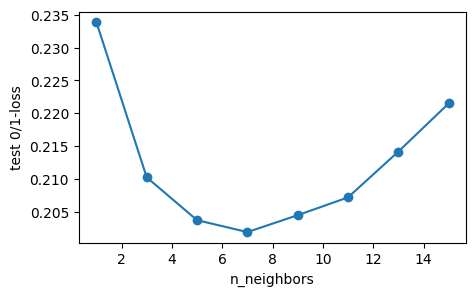

In [7]:
plt.figure(figsize=(5, 3))
plt.plot(N, loss.mean(axis=0))
plt.plot(N, loss.mean(axis=0), "o", color="C0")
plt.xlabel("n_neighbors")
plt.ylabel("test 0/1-loss")
plt.show()

In [397]:
n_neighbors = N[np.argmin(loss.mean(axis=0))]

n_repeats = 10000
model = KNeighborsClassifier(n_neighbors=n_neighbors)
loss = np.zeros(n_repeats)
for i in range(n_repeats):
    x_train, y_train = make_data(n_train)
    model.fit(x_train.reshape(-1, 1), y_train)
    loss[i] = zero_one_loss(y_test, model.predict(X_test))

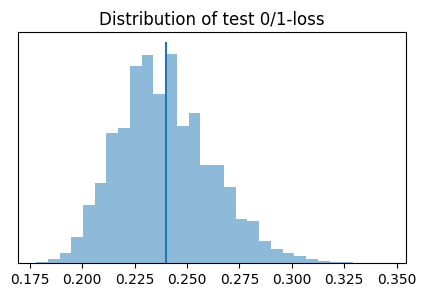

In [401]:
plt.figure(figsize=(5, 3))
plt.hist(loss, bins=30, alpha=0.5)
plt.title("Distribution of test 0/1-loss")
plt.plot([loss.mean(), loss.mean()], plt.ylim(), color="C0")
plt.yticks([])
plt.show()